In [1]:
from google.colab import drive ; drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers==3.4.0
!pip install pytypo
!pip install emoji
!pip install tensorflow==2.2.0
!pip install googletrans==3.1.0a0

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import pytypo
from re import sub,compile,UNICODE
import emoji
from collections import Counter
import transformers
import tensorflow_addons as tfa
import tensorflow as tf
from googletrans import Translator
pd.set_option("max_rows",None)

print(tf.__version__)
print('Keras version: %s' % tf.keras.__version__)
print(f"Transformes {transformers.__version__}")
MAX_LENGTH = 30
AUTO = tf.data.experimental.AUTOTUNE

2.2.0
Keras version: 2.3.0-tf
Transformes 3.4.0


In [4]:
dfTrain = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/train.csv",sep=",")
dfTest = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/test.csv",sep=",")

In [5]:
dfTrain.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


In [6]:
print(f"Row {dfTrain.shape[0]} \n Col {dfTrain.shape[1]}") # row = 14856, col = 3
print(f"Col Names {dfTrain.columns}") 

Row 14856 
 Col 3
Col Names Index(['review_id', 'review_text', 'category'], dtype='object')


In [7]:
dfTrain = dfTrain.drop(["review_id"] , axis=1) # Dropped
dfTrain.head()

,review_text,category
0,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,bocor lagi,0


In [8]:
print(f"How Many Nulls  ? {dfTrain['category'].isnull().sum()}") # 0
print(f"How Many Values For 1 and 0 \n{dfTrain['category'].value_counts()} ") # Imbalance (0 : 12839, 1 : 2017)


How Many Nulls  ? 0
How Many Values For 1 and 0 
0    12839
1     2017
Name: category, dtype: int64 


In [9]:
def clean_text(text):

  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 
  text_cleaning_num = "(^|\W)\d+"

  
  text = sub(text_cleaning_hash, " ", text).strip()
  text = sub(text_cleaning_num, " ", text).strip()
  text = sub(text_cleaning_re, " ", text).strip()
  text = text.lower().strip()
  text = "".join(text.split("."))  
  out = []
  for word in text.split() :
    out.append(word)

  return pytypo.correct_sentence(" ".join(out).strip())

clean_text("cleaning Gan.. 213213902183 httP:////........ ")

'cleaning gan http'

In [10]:
for i in range(0, len(dfTrain) // 3):
  print(f" Loc : {i} {dfTrain.loc[i,'review_text'] }" )

Streaming output truncated to the last 5000 lines.




















































































































 Loc : 1165 pelayanan receptionis kurang asyiek
tidak ada pelayanan menuju kamar
(suruh mencari sendiri) ANEH...!!!
 Loc : 1166 AC TIDAK DINGIN
AIR PANAS MATI
KAMAR KOTOR
 Loc : 1167 orang2 nya ramah, tetapi kamar tidak bersih ; lantainya kotor, dan kasurnya juga ada (maaf) beberapa pup cicak di bantal dan kasur, banyak semut di meja
 Loc : 1168 kamar tidur dan kmr mandi terlalu sempit, ada di gang yg tdk cocok bagi yg bawa mobil... hanya khusus backpacker dg motor saja yg bisa kesini
 Loc : 1169 kamar agak bau, pelayanan ok lah, kamar ga bisa di kunci
 Loc : 1170 tidak sesuai dengan yang ada di gambar
 Loc : 1171 kamar keliatan sepi ,ga ada lemari,meja,apa lagi kirsi,
kurang bersih juga,,
tp murah sih
thanks airy
 Loc : 1172 Pelayanan securitynya sangat tidak memuaskan yang berjaga digedung baru , 
 Loc : 1173 Temboknya 

In [11]:
def clean_emoji(text):
    emoji_patterns = compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=UNICODE)
    return emoji_patterns.sub(r'', text)
print(f"Before :{dfTrain.loc[14492  ,'review_text']}")
clean_emoji(dfTrain.loc[14492  ,"review_text"])

Before :kamarnya sempit, toilet apalagi, water heater y jg ga berfungsi. trus nemuin kelabang di lantai kamar dan di atas kasur, OMG😨😨😨


'kamarnya sempit, toilet apalagi, water heater y jg ga berfungsi. trus nemuin kelabang di lantai kamar dan di atas kasur, OMG'

In [12]:
dfTrain["review_text"] = dfTrain["review_text"].apply(clean_text)
dfTrain["review_text"] = dfTrain['review_text'].apply(clean_emoji)
print("Cleaned")

Cleaned


In [13]:
UniqueWord = set()
forCounter = []
def Uniques(df):
  for i in range(len(df)):
    Listeddesu = df.loc[i,"review_text"].split(" ")
    for j in Listeddesu:
      UniqueWord.add(j)
      forCounter.append(j)
Uniques(dfTrain)

In [14]:
print(f"There are : {len(UniqueWord)} words" )

There are : 13073 words


In [15]:
UniqueWord

{'',
 'ngit',
 'barangnya',
 'membilas',
 'anyar',
 'cemilan',
 'temen',
 'tante',
 'table',
 'buat2',
 'areal',
 'membandingkan',
 'm1',
 'mepet',
 'makar',
 'sebelum',
 'souvenir',
 'ikon',
 'hindari',
 'angka',
 'penyediian',
 'boats',
 'kisan',
 'homyy',
 'screencapture',
 'mantaap',
 'ruangan',
 'binggung',
 'keramahan',
 'giliran',
 'setrlay',
 'perkepala',
 'jangkau',
 'mengganggu',
 'relogin',
 'basah2an',
 'monitoring',
 'lapuk',
 'tnks',
 'jaringan',
 'ekepektasi',
 'sja',
 'aqua',
 'rewot',
 'psk',
 'bebek',
 'prosea',
 'serba',
 'bgs',
 'pesankan',
 'kit',
 'ditempel',
 'bad',
 'dlmnya',
 'kasitau',
 'pokonnya',
 'keluaga',
 'secepat',
 'mski',
 'pendaratan',
 'kampret',
 'apalgi',
 'rbut',
 'reguler',
 'such',
 'kongkow',
 'ketek',
 'sri',
 'sedkit',
 'lokasiinya',
 'brand',
 'berterbangan',
 'songong',
 'soekarno',
 'makananya',
 'pencetan',
 'hersihin',
 'prl',
 'mereka',
 'cicak',
 'awal',
 'ancur2',
 'melata',
 'mengalirnya',
 'seramm',
 'mencuri',
 'lift',
 'diinstagr

In [16]:
ShortWord = []
MediumWord = []

def takeShortestword(word):
  for i in word:
    if len(i) < 5:
      ShortWord.append(i)
  for i in word:
    if len(i) > 5 and len(i) < 8 :
      MediumWord.append(i)
takeShortestword(forCounter)
len(ShortWord) ,len(MediumWord)

(94368, 56905)

In [17]:
def delThewordLength1(text): 
  newtext = []
  for i in text.split(" "):
    if len(i) > 2:
      newtext.append(i)
    
  return " ".join(newtext)

  return newtext
    
delThewordLength1("d dlm kmr sinyal nya susah")

'dlm kmr sinyal nya susah'

In [18]:
dfTrain['review_text'] = dfTrain['review_text'].apply(delThewordLength1)


In [19]:
UniqueWord = set()
Uniques(dfTrain)
print(f"There are : {len(UniqueWord)} words" )

There are : 12816 words


In [20]:
ShortWord = sorted(dict(Counter(ShortWord)).items(),key= lambda dct:dct[1],reverse=True)

In [21]:
NeedTobefixedWord = []
ConsiderTheWord = []
for i in ShortWord:
  if i[1] > 100:
    NeedTobefixedWord.append(i)
  else:
    ConsiderTheWord.append(i)

len(NeedTobefixedWord),len(ConsiderTheWord)

(140, 2277)

In [22]:
for i in NeedTobefixedWord:
  print(i)

('dan', 5431)
('ada', 5008)
('di', 4694)
('nya', 2856)
('air', 2562)
('yg', 2522)
('saya', 2338)
('airy', 1940)
('ga', 1817)
('ac', 1748)
('yang', 1596)
('bau', 1486)
('gak', 1455)
('tdk', 1413)
('tapi', 1303)
('bisa', 1218)
('baik', 1107)
('juga', 1013)
('ke', 928)
('tv', 895)
('wifi', 846)
('dari', 822)
('ini', 741)
('jadi', 731)
('lagi', 707)
('jam', 707)
('agak', 706)
('in', 667)
('sama', 657)
('room', 593)
('tp', 591)
('mati', 583)
('cuma', 574)
('hari', 526)
('baru', 523)
('mau', 517)
('saat', 513)
('pas', 462)
('lama', 460)
('lain', 438)
('itu', 435)
('buat', 429)
('sy', 427)
('d', 406)
('saja', 397)
('aja', 394)
('kali', 389)
('the', 380)
('enak', 380)
('tamu', 350)
('oke', 338)
('gk', 332)
('kami', 330)
('dgn', 328)
('bgt', 324)
('ya', 324)
('utk', 321)
('pagi', 320)
('foto', 317)
('jd', 314)
('jg', 312)
('ok', 310)
('out', 303)
('sih', 302)
('bed', 298)
('luas', 287)
('krn', 286)
('dr', 276)
('jauh', 271)
('kmr', 267)
('and', 260)
('lah', 259)
('not', 251)
('sdh', 248)
('udah

In [39]:
FixtheWord = {"airy" : "air","gak":"tidak","tdk":"tidak","dgn":"dengan","bgt":"banget","utk":"untuk","krn":"karena","kmr":"kamar",
               "lha":"lah","sdh":"sudah","udah":"sudah",'kalo':'kalau',"dpt":"dapat","apek" : "bau",
               "ngga":"tidak","trus":"terus","org":"orang","klo":'kalau',"blm":"belum","tau":"tahu","dlm":"dalam"}


In [24]:
for i in ConsiderTheWord:
  if i[1] > 10 :
    print(i)
FixConsiderWord = {"udh":"sudah","gitu":"begitu","hrs":"harus","kmar":"kamar","pdhl":"padahal","msh":"masih",
                   "byk":"banyak"}

('awal', 100)
('oleh', 100)
('puas', 99)
('jika', 99)
('bawa', 98)
('stay', 98)
('udh', 98)
('cm', 98)
('cs', 97)
('it', 97)
('gitu', 96)
('siap', 96)
('lalu', 94)
('hrs', 93)
('nasi', 90)
('agar', 90)
('very', 87)
('kmar', 87)
('pdhl', 87)
('maaf', 87)
('msh', 86)
('was', 84)
('kena', 83)
('hot', 83)
('full', 83)
('alat', 82)
('krg', 82)
('sm', 81)
('byk', 81)
('kan', 81)
('gigi', 80)
('cat', 80)
('baju', 79)
('tisu', 77)
('kran', 77)
('buka', 75)
('tiba', 75)
('masa', 74)
('spt', 73)
('nice', 73)
('tpi', 72)
('jaga', 71)
('box', 71)
('hp', 69)
('chek', 69)
('hal', 69)
('all', 69)
('tiap', 68)
('k', 67)
('an', 66)
('of', 66)
('mlm', 66)
('dll', 64)
('staf', 63)
('dua', 63)
('lt', 61)
('gang', 61)
('kos', 61)
('aman', 60)
('lbh', 58)
('bagi', 58)
('sana', 57)
('sisa', 57)
('kata', 57)
('tmpt', 56)
('free', 55)
('biar', 55)
('area', 53)
('asap', 53)
('sya', 52)
('dah', 51)
('y', 50)
('jgn', 50)
('hati', 50)
('info', 49)
('up', 49)
('via', 48)
('sepi', 48)
('rasa', 48)
('dong', 48)
('my'

In [40]:
def FixIt(text):
  text = text.split(" ")
  index= 0
  for i in range(len(text)):
    if (text[i] in FixtheWord.keys()):
      text[i] = FixtheWord[text[i]]
  return " ".join(text)

FixIt("tdk tidak dgn mas")


'tidak tidak dengan mas'

In [26]:
dfTrain["review_text"] = dfTrain["review_text"].apply(FixIt)

In [46]:
def TranslateGan(text):
  translator = Translator()
  ans = translator.translate(text.split(" "),dest="id")
  return ans[0].text

TranslateGan("Where are you")

'Where'

In [38]:
for i in range(len(dfTrain["review_text"])):
  print(i, dfTrain.loc[i,"review_text"])
translatein = [10067,]

Streaming output truncated to the last 5000 lines.
9856 bau rokok wifi mati saluran cuman ndak jelas semua
9857 ruangan diberikan tidak baik debuan dan furniture kurang terawat
9858 malam nginap tiap malam ada semut berkeliaran sampai naik dkatas kasur dan menggigit nyamuk juga ada ekor handuk tidak pernah diganti kamar bau rokok
9859 air kurang bagus berbau
9860 kamar mandinya ada kecoa kamarnya kurang nyaman aja overall bagus sih
9861 pertama datang tidak ada resepsionis begitu masuk kamar ada ekor kecoa mati lantai ekor kecoa hidup tembok resepsionis merangkap room boy tidak tanggap terkesan bingung harus berbuat apa setelah diminta mencari pembasmi serangga dan disemprotkan seluruh kamar muncul ekor kecoa lagi pemilik seolah membiarkan hal ini
9862 ketika menginap mengharapakan kenyamanan namun disana tidak ada wifi dan air panas dan bednya ada per menonjol yang membuat saya berdarah dan tidak ada p3k saat itu pelayanan kurang baik takut ada hal tidak inginkan saya lasung pindah ho

In [113]:
## Build the Deep Learning model
from transformers import AutoTokenizer,TFAutoModel,AutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
from sklearn.model_selection import train_test_split

In [148]:
X_train,x_val,y_train,y_val = train_test_split(dfTrain["review_text"],dfTrain["category"],test_size=0.03,random_state=102)
len(X_train), len(y_train)
print(y_val.value_counts())

0    375
1     71
Name: category, dtype: int64


In [149]:
tokens_dfTrain = {
    "review_text": tokenizer.batch_encode_plus(
        X_train.tolist(),
        max_length = MAX_LENGTH,
        pad_to_max_length = True,
        truncation = True)
}
tokens_dfVal = {
    "review_text": tokenizer.batch_encode_plus(
        x_val.tolist(),
        max_length= MAX_LENGTH,
        truncation=True,
        pad_to_max_length= True
    )

    }
train_data ={
        "review_text": tf.convert_to_tensor(tokens_dfTrain["review_text"]["input_ids"]),
        "review_text_mask":tf.convert_to_tensor(tokens_dfTrain["review_text"]["attention_mask"])
}
val_data = {
        "review_text" : tf.convert_to_tensor(tokens_dfVal["review_text"]["input_ids"]),
        "review_text_mask" : tf.convert_to_tensor(tokens_dfVal["review_text"]["attention_mask"])
}
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

y_train = tf.keras.utils.to_categorical(y_train,2)
y_val = tf.keras.utils.to_categorical(y_val,2)
print(y_train[1:5])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [150]:
dataset = (tf.data.Dataset.from_tensor_slices((train_data,y_train))
.batch(32)
.prefetch(AUTO))

dataVal = (tf.data.Dataset.from_tensor_slices((val_data,y_val))
.batch(32)
.prefetch(AUTO)
.cache())

In [152]:
def CreateDLModel():

  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="review_text")
  att1 = tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="review_text_mask")


  embedding,SeqOutput = IndoBert(ids1,attention_mask=att1)

  finlayer = tf.keras.layers.Dropout(0.3)(embedding)
  finlayer = tf.keras.layers.Dense(256,tf.nn.relu)(finlayer)
  finlayer = tf.keras.layers.Dense(64,tf.nn.relu)(finlayer)
  finlayer = tf.keras.layers.Flatten()(finlayer)
  
  
  theFinal = tf.keras.layers.Dropout(0.35)(finlayer)
  theFinal = tf.keras.layers.Dense(16,tf.nn.relu)(theFinal)
  theFinal = tf.keras.layers.Dense(2,activation=tf.nn.softmax)(theFinal)



  final = tf.keras.Model([ids1,att1],[theFinal])
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ] 
  
  optimizer = tf.keras.optimizers.Adam()
  final.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),optimizer=optimizer,
               metrics=METRICS)

  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[-4:]:
      layer.trainable = True

  return final

model = CreateDLModel()

In [153]:
import math
def create_learning_rate_scheduler(max_learn_rate=1e-2,
                                   end_learn_rate=1e-6,
                                   warmup_epoch_count=3,
                                   total_epoch_count=15):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = max_learn_rate
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

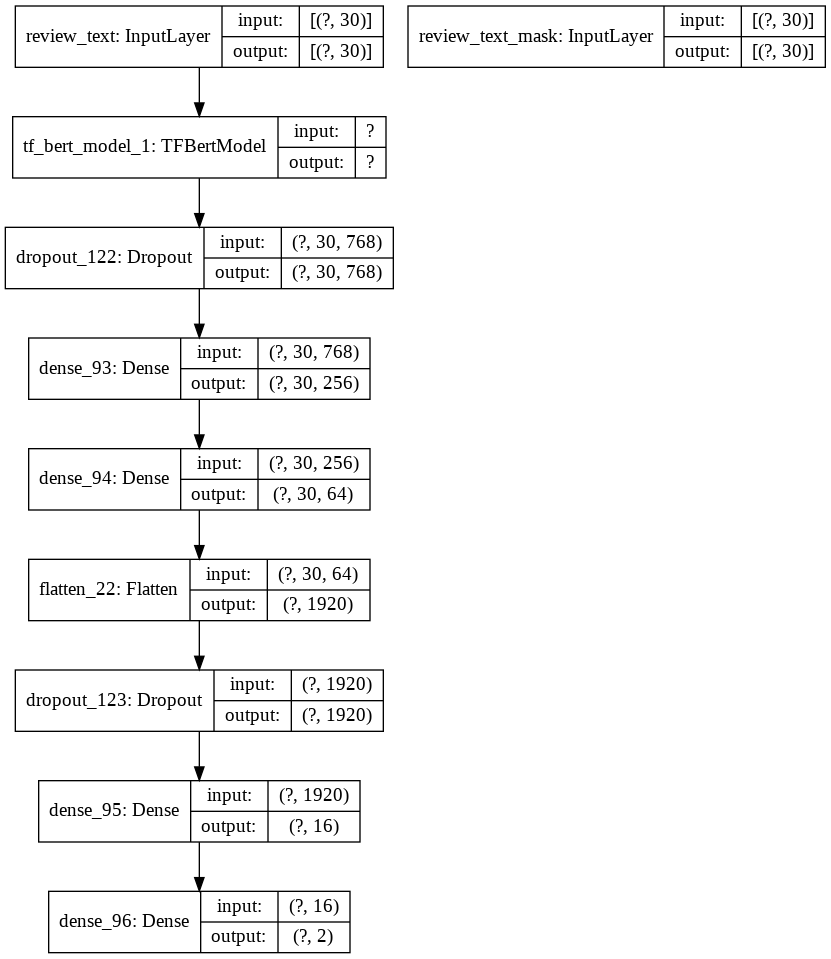

In [154]:
tf.keras.utils.plot_model(model,"modelarhcitect.png",show_shapes=True)

In [155]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
review_text (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
review_text_mask (InputLayer)   [(None, 30)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   multiple             124441344   review_text[0][0]                
__________________________________________________________________________________________________
dropout_122 (Dropout)           (None, 30, 768)      0           tf_bert_model_1[4][0]            
___________________________________________________________________________________________

In [102]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience = 6)

In [ ]:
for element in dataset:
  print(element)

In [156]:
history3=model.fit(x = dataset,epochs = 10,validation_data=dataVal,callbacks = [EarlyStop, create_learning_rate_scheduler(max_learn_rate=1e-4,
                                                 end_learn_rate=1e-6,
                                                    warmup_epoch_count=5,
                                                    total_epoch_count=15),EarlyStop])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
451/451 [==============================] - 42s 94ms/step - loss: 0.0828 - tp: 12805.0000 - fp: 1605.0000 - tn: 12805.0000 - fn: 1605.0000 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9451 - val_loss: 0.0513 - val_tp: 419.0000 - val_fp: 27.0000 - val_tn: 419.0000 - val_fn: 27.0000 - val_accuracy: 0.9395 - val_precision: 0.9395 - val_recall: 0.9395 - val_auc: 0.9780 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/10
451/451 [==============================] - 38s 85ms/step - loss: 0.0524 - tp: 13463.0000 - fp: 947.0000 - tn: 13463.0000 - fn: 947.0000 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9764 - val_loss: 0.0446 - val_tp: 420.0000 - val_fp: 26.0000 - val_tn: 420.0000 - val_fn: 26.0000 - val_accuracy: 0.9417 - val_precision: 0.9417 - val_recall: 0.9417 - val_auc: 0.9824 - lr: 1.0000e-04

Epoch 00003: LearningRateSchedu

In [157]:
# Test ---
dfTest["review_text"] = dfTest["review_text"].apply(clean_text)
dfTest["review_text"] = dfTest["review_text"].apply(clean_emoji)
dfTest["review_text"] = dfTest["review_text"].apply(FixIt)

tokens_dftest = {
    "review_text": tokenizer.batch_encode_plus(
        dfTest["review_text"].tolist(),
        max_length= MAX_LENGTH,
        truncation=True,
        pad_to_max_length= True
    )}

dfTestdataset = {
        "review_text": tf.convert_to_tensor(tokens_dftest["review_text"]["input_ids"]),
        "review_text_mask":tf.convert_to_tensor(tokens_dftest["review_text"]["attention_mask"])
}


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [66]:
y_pred = np.argmax(model.predict(dfTestdataset),axis = 1)
y_pred[1:15]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [70]:
dfTestAns = pd.DataFrame(dfTest["review_id"])
dfTestAns['category'] =y_pred

In [74]:
dfTestAns.to_csv("SubmitGan.csv",index=False)

In [139]:
y_pred2 = np.argmax(model.predict(dfTestdataset),axis = 1)
y_pred[1:15]
dfTestAns2 = pd.DataFrame(dfTest["review_id"])
dfTestAns2['category'] =y_pred2

In [95]:
print(dfTestAns["category"].value_counts() )
print(dfTestAns2['category'].value_counts())

0    3275
1     439
Name: category, dtype: int64
0    3277
1     437
Name: category, dtype: int64


In [142]:

dfTestAns2.to_csv("SubmitLast.csv",index=False)

In [143]:
print(dfTestAns["category"].value_counts() )
print(dfTestAns2['category'].value_counts())

0    3275
1     439
Name: category, dtype: int64
0    3244
1     470
Name: category, dtype: int64
